# Data compilation
Uses Aus datasets for the GAB region as an example, but can be modified to extract data for any region

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import rasterio
import rioxarray
import geopandas as gpd

%matplotlib inline

In [2]:
def transform_coordinates(x, y, epsg_in, epsg_out):
    """
    Transform between any coordinate system.
    **Requires `pyproj`** - install using pip.
    Args:
        x : float / 1D array
            x coordinates (may be in degrees or metres/eastings)
        y : float / 1D array
            y coordinates (may be in degrees or metres/northings)
        epsg_in : int
            CRS of x and y coordinates
        epsg_out : int
            CRS of output
    Returns:
        x_out : float / list of floats
            x coordinates projected in `epsg_out`
        y_out : float / list of floats
            y coordinates projected in `epsg_out`
    """
    import pyproj

    proj_in = pyproj.CRS("EPSG:" + str(epsg_in))
    proj_out = pyproj.CRS("EPSG:" + str(epsg_out))
    transformer = pyproj.Transformer.from_crs(proj_in, proj_out, always_xy=True)
    return transformer.transform(x,y)

In [3]:
### Use a bounding box in the model coordinate system to extract data in the area of interest
xmin, xmax, ymin, ymax = -955637.8812, 1034362.2443650428, 6342298.2975, 8922298.39436168

### Set to directory where all input data is stored
Also where all converted data will be stored

In [4]:
data_dir = r'../Data/'

## Temperature data
OzTemp available [Here](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/70604)

In [ ]:
### load in file that contains the dataset
tempData = pd.read_csv(data_dir + "temperature_data/OzTemp_UncertaintyAssessment_GAB.csv")

# convert to eastings / northings,
tempData_eastings, tempData_northings = transform_coordinates(tempData["GDA94 Long (DD)"].to_numpy(),
                                                          tempData["GDA94 Lat (DD)"].to_numpy(),
                                                          epsg_in=4326, epsg_out=28355)




In [ ]:
# save to data folder, the headers may need to be updated to those contained in the folder

df_tempData = pd.DataFrame()
df_tempData['Hole No']   = tempData['Hole No']
df_tempData['Well Name'] = tempData['Well Name']
df_tempData['Longitude'] = tempData["GDA94 Long (DD)"]
df_tempData['Latitude']  = tempData["GDA94 Lat (DD)"]
df_tempData['Eastings']  = tempData_eastings
df_tempData['Northings'] = tempData_northings
df_tempData['Depth']     = tempData['Depth of Temp (m)']
df_tempData['Temperature'] = tempData['Mu']
df_tempData['Temperature stdev'] = tempData['Sigma']



In [ ]:
### extract area of interest
df_tempData_bbox = df_tempData[(gw_data['Eastings'] >= xmin) & (df_tempData['Eastings'] <= xmax) & 
                       (df_tempData['Northings'] >= ymin) & (df_tempData['Northings'] <= ymax)]

### save
df_tempData_bbox.to_csv(data_dir + "temperature_OzTemp.csv", index=False)

## Recharge data
GAB recharge estimates available [Here](https://data.gov.au/data/dataset/fb93be54-4101-4130-9138-215bec4bdad0)

In [ ]:
file_name = data_dir + 'rch_fnl2_mmyr.xyz'

with rasterio.open(file_name) as src:
    band1 = src.read(1)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    xcoords = np.array(xs)
    ycoords = np.array(ys)
    
### convert coords
recharge_eastings, recharge_northings = transform_coordinates(xcoords, ycoords, epsg_in=4326, epsg_out=28355)


In [ ]:
recharge_data = pd.DataFrame()
recharge_data['eastings'] = recharge_eastings.flatten()
recharge_data['northings'] = recharge_northings.flatten()
recharge_data['rechange'] = band1.flatten()

### remove NaN values
recharge_data = recharge_data[recharge_data['rechange'] > 0]

### extract area of interest
recharge_data_bbox = recharge_data[(recharge_data['eastings'] >= xmin) & (recharge_data['eastings'] <= xmax) & 
                                   (recharge_data['northings'] >= ymin) & (recharge_data['northings'] <= ymax)]

recharge_data

## Groundwater pressure head

NGIS groundwater data for Australia can be downloaded from the [BOM groundwater explorer](http://www.bom.gov.au/water/groundwater/explorer/map.shtml)

Uses values from pre 2000 to reduce anthropogenic effects


In [5]:
import shapefile
import cartopy.io.shapereader as shpreader
import csv
import rasterio
from scipy.interpolate import RegularGridInterpolator

In [34]:
def read_bore_shapefile(shape_filename):
    """
    Read borehole information from NGIS shapefile
    
    Arguments
    ---------
    shape_filename : str
        file path of the NGIS shapefile
    
    Returns
    -------
    boreID : array shape(n,)
        unique borehole identifier
    lonlat : array shape(n,2)
        longitudinal / latitudinal coordinates
    coords : array shape(n,2)
        eastings / northings in local projected coordinates
    proj : array shape(n,)
        local projection number
    elevation : array shape(n,)
        elevation above sea level to well casing
    """
    shp = shpreader.Reader(shape_filename)

    n_entries = len(shp)
    coords_lonlat = np.empty((n_entries,2))
    coords_proj   = np.empty((n_entries,2))
    proj          = np.empty(n_entries, dtype=int)
    elevation     = np.empty(n_entries)
    hydroID       = np.empty(n_entries, dtype=int)
    hydroCode     = [[]]*n_entries
    is_hydro      = np.empty(n_entries, dtype=bool)
    drilled_depth = np.empty(n_entries)

    i = 0
    for record in shp.records():
        hydroID[i]       = record.attributes['HydroID']
        hydroCode[i]     = record.attributes['HydroCode']
        proj[i]          = record.attributes['Projecti_1']
        coords_lonlat[i] = record.attributes['Longitude'], record.attributes['Latitude']
        coords_proj[i]   = record.attributes['Easting'], record.attributes['Northing']
        elevation[i]     = record.attributes['RefElev']
        drilled_depth[i] = record.attributes['DrilledDep']
        is_hydro[i]      = record.attributes['WaterCount']
        i += 1

    shp.close()
    hydroCode = np.array(hydroCode)
    mask = np.logical_and(is_hydro, drilled_depth > 0)
    
    return (hydroID[mask], hydroCode[mask], \
            coords_lonlat[mask], coords_proj[mask], proj[mask], \
            elevation[mask], drilled_depth[mask])

def read_water_levels(levels_filename, boreID, elevation, min_date=None, max_date=None):
    """
    Read water level information from levels.csv for given boreID
    
    Arguments
    ---------
    levels_filename : str
        path to levels.csv file
    boreID : array shape(n,)
        unique borehole identifier
    min_date : datetime
        include entries greather than or equal to this datetime
    max_date : datetime
        include entries less than this datetime
    
    Returns
    -------
    levels : array shape(n,)
        mean water level in each borehole corresponding to their boreID
    levels_std : array shape(n,)
        standard deviation of water level in each borehole
    """
    bID, level = np.loadtxt(levels_filename, delimiter=',', usecols=(0,5), skiprows=1, unpack=True)
    date  = np.loadtxt(levels_filename, delimiter=',', usecols=(3,), skiprows=1, unpack=True, dtype=np.datetime64)
    datum = np.loadtxt(levels_filename, delimiter=',', usecols=(4,), skiprows=1, unpack=True, dtype=str)
    bID = bID.astype(int)

    if min_date is None and max_date is None:
        pass
    else:    
        # create a range if min_date or max_date is not NoneType
        if min_date is None:
            min_date = np.datetime64('0')
        if max_date is None:
            max_date = np.datetime64('3000')
        
        # filter data to within date range
        mask_date = np.logical_and(date >= min_date, date < max_date)
        bID = bID[mask_date]
        level = level[mask_date]
        datum = datum[mask_date]
        
    mean_std_levels = np.empty((len(boreID), 2))

    for i, ID in enumerate(boreID):
        mask_ID = bID == ID
        if mask_ID.any():
            level_ID = level[mask_ID]
            datum_ID = datum[mask_ID]
            mask_RSWL = datum_ID == 'RSWL (mAHD)'
            mask_DTW  = datum_ID == 'DTW'
            mask_SWL  = datum_ID == 'SWL'
            
            if mask_DTW.any():
                mean_std_levels[i] = np.mean(level_ID[mask_DTW]), np.std(level_ID[mask_DTW])
            elif mask_SWL.any():
                mean_std_levels[i] = np.mean(level_ID[mask_SWL]), np.std(level_ID[mask_SWL])
        else:
            mean_std_levels[i] = np.nan
            
    return tuple(mean_std_levels.T)


#### Import elevation

In [35]:
topo1_filename = data_dir + 'bathymetry_e100s10.tif'
topo2_filename = data_dir + 'bathymetry_e140s10.tif'
topo1_file = rasterio.open(topo1_filename)
topo2_file = rasterio.open(topo2_filename)

topo_grid = np.hstack([topo1_file.read(1), topo2_file.read(1)])

extent_topo = topo1_file.bounds.left, topo2_file.bounds.right, topo2_file.bounds.top, topo2_file.bounds.bottom

topo1_file.close()
topo2_file.close()

topo_lons = np.linspace(extent_topo[0], extent_topo[1], topo_grid.shape[1])
topo_lats = np.linspace(extent_topo[2], extent_topo[3], topo_grid.shape[0])

# set up interpolator
topo_interp = RegularGridInterpolator((topo_lats, topo_lons), topo_grid)

print(extent_topo)

(100.00416666666666, 179.99583333333334, -59.99583333333333, -10.00416666666667)


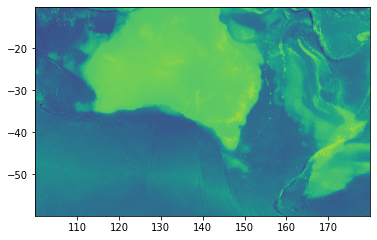

In [36]:
plt.imshow(topo_grid, origin='lower', extent=extent_topo)

#### Extract borehole data from shapefiles

In [37]:
states  =  ["NSW", "VIC", "ACT", "SA", "QLD", "TAS", "NT", "WA"]
shapefilename = data_dir + "NGIS_boreholes/shp_{0}/NGIS_Bore.shp"
levelfilename = data_dir + "NGIS_boreholes/shp_{0}/level_{0}.csv"


gw_data = []
for state in states:
    sf_state = read_bore_shapefile(shapefilename.format(state))
    
    # bore lon lat coords
    gw_lons = sf_state[2][:,0]
    gw_lats = sf_state[2][:,1]
    
    # interpolate elevation
    gw_elev = topo_interp((gw_lats, gw_lons))
    
    # extract groundwater levels
    gw_level = read_water_levels(levelfilename.format(state), sf_state[0], gw_elev, None, np.datetime64('2000'))
    
    # concatenate arrays
    gw_state = np.hstack([np.c_[sf_state], np.c_[gw_level]])
    gw_state[:,7] = gw_elev
    gw_state = gw_state[~np.isnan(gw_level[0])] # mask out no entries
    
    gw_data.append(gw_state)
    print("Completed {}".format(state))

# concatenate data
gw_data = np.vstack(gw_data)
gw_ID         = gw_data[:,0].astype(int)
gw_code       = gw_data[:,1]
gw_lonlat     = gw_data[:,2:4].astype(float)
gw_coords     = gw_data[:,4:6].astype(float)
gw_proj       = gw_data[:,6].astype(float)
gw_elevation  = gw_data[:,7].astype(float)
gw_depth      = gw_data[:,8].astype(float)
gw_level      = gw_data[:,9].astype(float)
gw_level_std  = gw_data[:,10].astype(float)

Completed NSW
Completed VIC
Completed ACT
Completed SA
Completed QLD
Completed TAS
Completed NT
Completed WA


In [38]:
topo_file = rasterio.open('../data/GAB_surfaces/GeoTiff/AUSBATH09_AMG55_GDA94_500m_model_extent.tiff')
gab_topo_grid = np.flipud(topo_file.read(1, masked=True))
gab_topo_mask = gab_topo_grid >= topo_file.nodata
gab_topo_grid[gab_topo_mask] = np.nan
extent_gab_topo = topo_file.bounds.left, topo_file.bounds.right, topo_file.bounds.bottom, topo_file.bounds.top
topo_file.close()

gab_topo_eastings = np.linspace(extent_gab_topo[0], extent_gab_topo[1], gab_topo_grid.shape[1])
gab_topo_northings = np.linspace(extent_gab_topo[2], extent_gab_topo[3], gab_topo_grid.shape[0])

# GAB topo interpolator
gab_topo_interp = RegularGridInterpolator((gab_topo_northings, gab_topo_eastings),gab_topo_grid,bounds_error=False)

# convert lon / lat to eastings / northings
gw_eastings, gw_northings = transform_coordinates(gw_lonlat[:,0], gw_lonlat[:,1], epsg_in=4326, epsg_out=28355)
gw_coords = np.c_[gw_eastings, gw_northings]
gw_data[:,4:6] = gw_coords

# interpolate topo inside GAB
gw_topo = gab_topo_interp((gw_northings, gw_eastings))

mask_bbox =((gw_eastings >= xmin)  & (gw_eastings <= xmax) & 
            (gw_northings >= ymin) & (gw_northings <= ymax))


mask_gab = np.isfinite(gw_topo)
# # points inside GAB will be 0 - keep these
# mask_gab = np.logical_and(mask_bbox, gw_elevation_mask == 0)

#### Convert coordinate system of gw data

In [39]:
### Save
columns = ['hydroID', 'hydroCode', 'lon', 'lat','easting','northing','projection','elevation',
           'gw_bore_depth', 'gw_level', 'gw_level_std']

df_head = pd.DataFrame(gw_data, columns=columns)
df_head.to_csv(data_dir + 'NGIS_groundwater_levels_to_2000.csv', index=False)

df_head_bbox = pd.DataFrame(gw_data[mask_bbox], columns=columns)
df_head_bbox.to_csv(data_dir + 'NGIS_groundwater_levels_to_2000_bbox.csv', index=False)

df_head_gab = pd.DataFrame(gw_data[mask_gab], columns=columns)
df_head_gab.to_csv(data_dir + 'NGIS_groundwater_levels_to_2000_GAB.csv', index=False)

## Water table

The water table is essentially the longwavelength topography. We want to cut out the short wavelength topography, i.e. mountains, which we can accomplish using a minimum filter `scipy.ndimage.percentile_filter(...)`.

Australian topography can be accessed [here](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/67703).

The result can be compared to the water table derived from the GABWRA project which is available [here](https://data.gov.au/dataset/ds-dga-8d1a9fbc-a411-4ac3-b471-7bb81dcaa45b/details).

In [ ]:
topography = rioxarray.open_rasterio(data_dir + 'AUSBATH09_AMG55_GDA94_500m_model_extent.tiff')


In [ ]:
# set up interpolator
smooth_topo_interp = RegularGridInterpolator((np.flipud(topography.sel(band=1).y.data), topography.sel(band=1).x.data), np.flipud(topography.sel(band=1).data), bounds_error=False)




In [ ]:
wt_file = rasterio.open(data_dir + 'GAB_WaterTable_GABWRA_v01/wt.gtiff.tif')
wt_data = np.flipud(wt_file.read(1, masked=True))
wt_extent = wt_file.bounds.left, wt_file.bounds.right, wt_file.bounds.bottom, wt_file.bounds.top
wt_file.close()

# get coordinates
wt_xcoords = np.linspace(wt_extent[0], wt_extent[1], wt_data.shape[1], endpoint=False)
wt_ycoords = np.linspace(wt_extent[2], wt_extent[3], wt_data.shape[0], endpoint=False)
wt_xq, wt_yq = np.meshgrid(wt_xcoords, wt_ycoords)

# mask coordinates in GAB
wt_x = wt_xq[~wt_data.mask]
wt_y = wt_yq[~wt_data.mask]
wt_z = np.array(wt_data[~wt_data.mask])

In [ ]:

percentile_range = [1, 5, 10, 15]
size_range = [5, 15, 25, 35]

grid_range = np.zeros((len(percentile_range), len(size_range)))

for i, percentile in enumerate(percentile_range):
    for j, size in enumerate(size_range):
        elevation = topo_data.copy()
        elevation[elevation < -10] = -10
        
        smooth_elevation = ndimage.percentile_filter(elevation, percentile, size=size)
        smooth_topo_interp.values = smooth_elevation
        smooth_elevation_interp = smooth_topo_interp((wt_y, wt_x))
        
        misfit = np.nansum((smooth_elevation_interp - wt_z)**2)
        grid_range[i,j] = misfit
        
        print("p{:2.1f}, s{:2d}, l-2 misfit = {:.02e}".format(percentile, size, misfit))

In [ ]:
# Pick best solution

i, j = np.where(grid_range == grid_range.min())
percentile = percentile_range[int(i)]
size = size_range[int(j)]
print("Optimal percentile = {}, size = {}".format(percentile, size))

plt.pcolor(percentile_range, size_range, grid_range, shading='auto', )

In [ ]:
def fill_ndimage(data,invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid')
    by the value of the nearest valid data cell
    """
    from scipy.ndimage import distance_transform_edt
    masked_array = hasattr(data, "fill_value")
    if masked_array:
        mask_fill_value = data.data == data.fill_value
        data = data.data.copy()
        data[mask_fill_value] = np.nan
    else:
        data = data.copy()

    if invalid is None:
        invalid = np.isnan(data)
        if masked_array:
            invalid += mask_fill_value
    ind = distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

# set up water table interpolators
wt_interp = RegularGridInterpolator((wt_ycoords, wt_xcoords), fill_ndimage(wt_data), bounds_error=False)
wt_interp_nan = RegularGridInterpolator((wt_ycoords, wt_xcoords), wt_data.mask.astype(int),
                                        bounds_error=False, fill_value=1)

# interpolate water table to DEM grid
topo_xq, topo_yq = np.meshgrid(topo_xc, topo_yc)
topo_zq = wt_interp((topo_yq, topo_xq), method='linear')

# mask regions that are outside GAB
topo_zq_mask = wt_interp_nan((topo_yq, topo_xq), method='nearest')
topo_zq[topo_zq_mask==1] = np.nan


# place inside topo_data and smoooooth
elevation = topo_data.copy()
elevation[elevation < -10] = -10
elevation[~np.isnan(topo_zq)] = topo_zq[~np.isnan(topo_zq)]
smooth_elevation = ndimage.percentile_filter(elevation, percentile, size=size)
smooth_elevation = fill_ndimage(smooth_elevation) # no gaps

In [ ]:
elevation_diff = elevation - smooth_elevation


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))

im1 = ax1.imshow(smooth_elevation, origin='lower', extent=topo_extent, vmin=-10, vmax=1000)
im2 = ax2.imshow(topo_data, origin='lower', extent=topo_extent, vmin=-10, vmax=1000)
im3 = ax3.imshow(elevation_diff, origin='lower', extent=topo_extent, cmap='BrBG', vmin=-200, vmax=200)

ax1.set_title('Smooth')
ax2.set_title('Original')
ax3.set_title("Diff")

In [ ]:
# save water table

np.savez_compressed(data_dir + "water_table_surface.npz",
                    data=elevation_diff,
                    x=topo_xc, y=topo_yc, extent=topo_extent)
